# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag ='GHGEmissionsIntensity'
target = data_num[target_tag]
sqf = data_num['PropertyGFABuilding(s)']
data_num = data_num.drop(labels = [target_tag,'SiteEnergyUse(kBtu)', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 522 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(522)
memory usage: 6.5 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [6]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [7]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

In [18]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    y_train= np.array(np.exp(y_train)).reshape(-1,1)
    pred_train = np.array(np.exp(pred_train)).reshape(-1,1)
    y_test = np.array(np.exp(y_test)).reshape(-1,1)
    pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
    
    
    
    y_train = (y_train/1000)*sqftrain
    pred_train = (pred_train/1000)*sqftrain
    
    line_reg_train = line_reg.fit(pred_train,y_train)
    r2_train = line_reg_train.score(pred_train,y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(y_train))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')

    y_test = (y_test/1000)*sqftest
    pred_test = (pred_test/1000)*sqftest
    
    line_reg_test  = line_reg.fit(pred_test,y_test)
    r2_test =  line_reg_test.score(pred_test,y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(y_test))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

E:\temp\ipykernel_15100\2894403746.py:7: RuntimeWarning: overflow encountered in exp
  pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

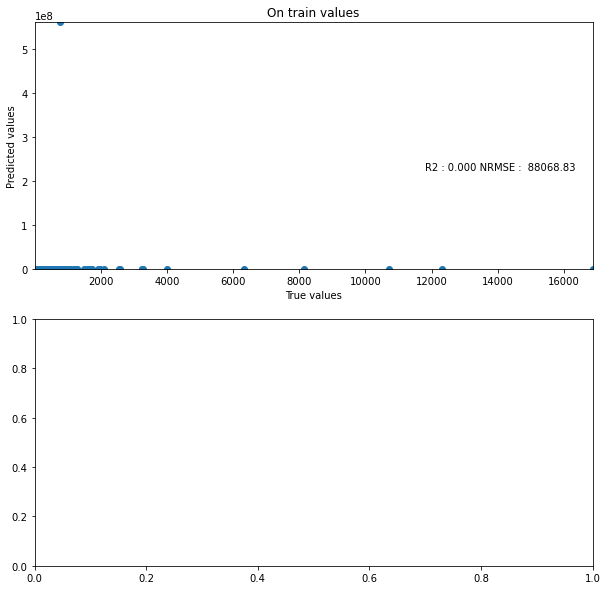

In [33]:
line_reg_m = linear_model.LinearRegression()

model_lr = line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain,  model_lr.predict(xtrain), ytest,  model_lr.predict(xtest))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 7}
GridCV results : 
r2 = -0.065 (+/- 0.113) for {'n_neighbors': 2}
r2 = 0.086 (+/- 0.071) for {'n_neighbors': 3}
r2 = 0.129 (+/- 0.092) for {'n_neighbors': 4}
r2 = 0.149 (+/- 0.111) for {'n_neighbors': 5}
r2 = 0.161 (+/- 0.101) for {'n_neighbors': 6}
r2 = 0.172 (+/- 0.071) for {'n_neighbors': 7}
r2 = 0.165 (+/- 0.065) for {'n_neighbors': 8}
r2 = 0.166 (+/- 0.057) for {'n_neighbors': 9}
r2 = 0.157 (+/- 0.046) for {'n_neighbors': 10}
r2 = 0.146 (+/- 0.038) for {'n_neighbors': 11}
r2 = 0.144 (+/- 0.048) for {'n_neighbors': 12}
r2 = 0.142 (+/- 0.044) for {'n_neighbors': 13}
r2 = 0.133 (+/- 0.030) for {'n_neighbors': 14}
r2 = 0.132 (+/- 0.037) for {'n_neighbors': 15}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


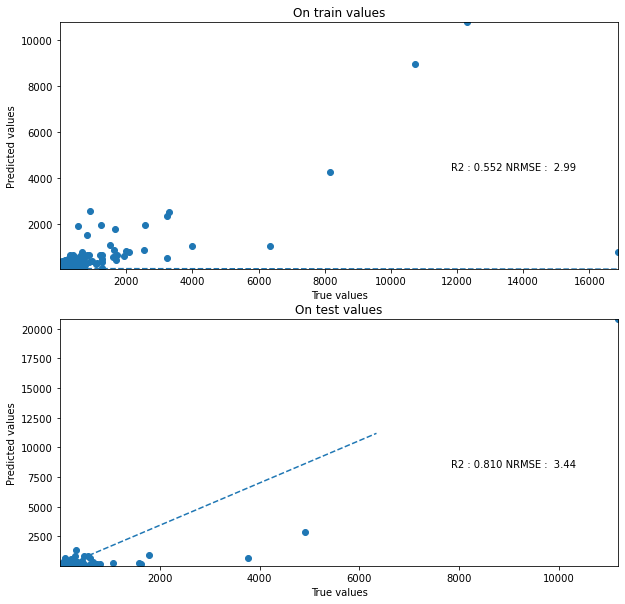

<Figure size 432x288 with 0 Axes>

In [35]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))
    
model_kn = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_kn.predict(xtrain), ytest, model_kn.predict(xtest))

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


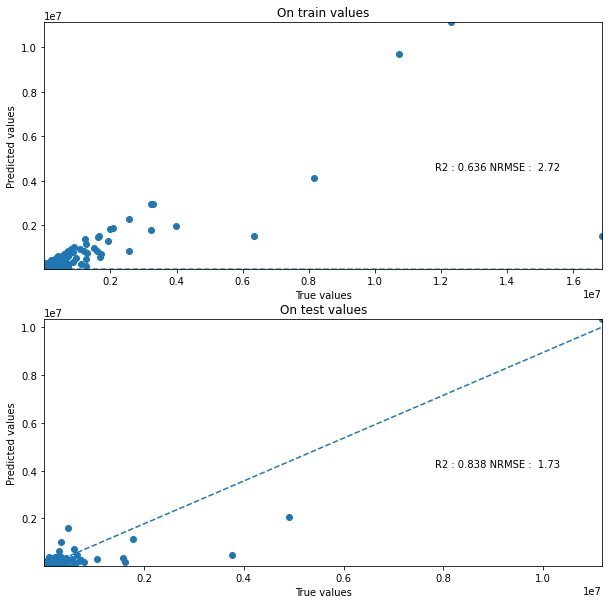

<Figure size 432x288 with 0 Axes>

In [14]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    #let's try with a svr
    C_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'rbf', 'sigmoid', 'poly']
    degrees = [2,3,4]
    gamma_range  = np.logspace(-2, 1, 10)
    #gamma_range = np.logspace(-2, 1, 10)
    #'gamma' : gamma_range
    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

    score = 'neg_mean_squared_error'

    svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

    svr_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(svr_cv.best_params_))
bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
model_svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model_svr.predict(xtrain), ytest, model_svr.predict(xtest))

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best params on training set : {'alpha': 100.0, 'degree': 3, 'gamma': 10.0, 'kernel': 'rbf'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


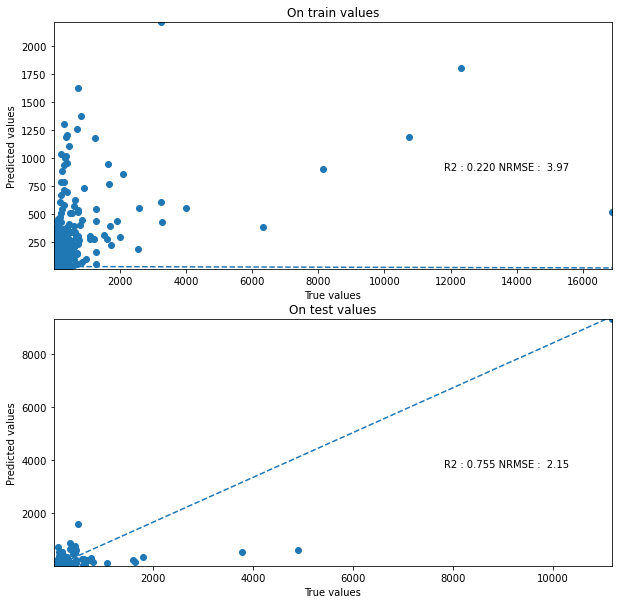

<Figure size 432x288 with 0 Axes>

In [37]:
from sklearn import kernel_ridge
#let's try with a ridge regression

x = input('Do you want to launch ? [y/n]')
if x == 'y':
    alpha_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'poly', 'rbf']
    degrees = [3,4,5]
    gamma_range  = np.logspace(-2, 1, 10)


    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
    score = 'neg_mean_absolute_percentage_error'

    kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

    kernel_ridge_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))
    
bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model_kr = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model_kr.predict(xtrain), ytest, model_kr.predict(xtest))

## Neural network

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 523       
                                                                 
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 1s 888us/step - loss: 4435604.0000 - root_mean_squared_error: 1.7082
Epoch 2/50
1304/1304 [==============================] - 1s 880us/step - loss: 3319327.5000 - root_mean_squared_error: 1.7077
Epoch 3/50
1304/1304 [==============================] - 1s 878us/step - loss: 3098547.2500 - root_mean_squared_error: 1.6958
Epoch 4/50
1304/1304 [==============================] - 1s 886us/step - loss: 2581466.5000 - root_mean_squared_error: 1.7194
Epoch 5/50
1304/1304 [==============================] - 1s 867us/step - loss: 1910194.

11/11 [==============================] - 0s 903us/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


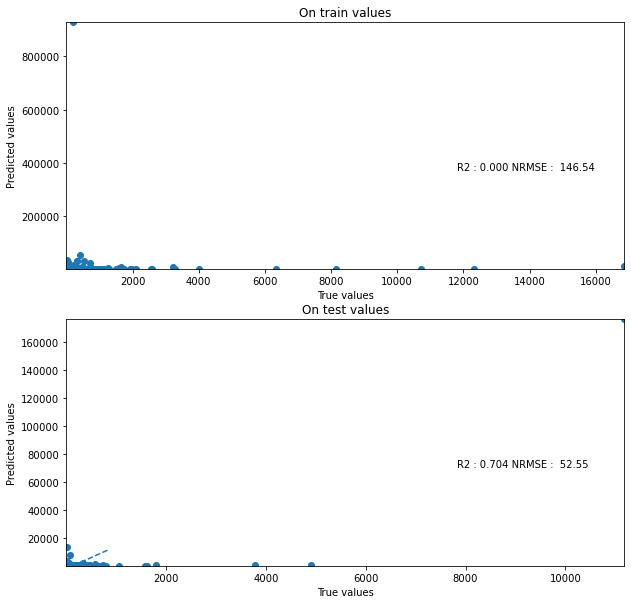

<Figure size 432x288 with 0 Axes>

In [24]:
true_pred_plot(ytrain, model1.predict(xtrain), ytest, model1.predict(xtest))

In [25]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 522)               273006    
                                                                 
 layer2 (Dense)              (None, 287)               150101    
                                                                 
 layer3 (Dense)              (None, 1)                 288       
                                                                 
Total params: 423,395
Trainable params: 423,395
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 3s 2ms/step - loss: 5411913.5000 - root_mean_squared_error: 1.9792
Epoch 2/50
1304/1304 [==============================] - 3s 2ms/step - loss: 38152212.0000 - root_mean_squared_error: 3.8493
Epoch 3/50
1304/1304 [==============================] - 3s 2ms/st

11/11 [==============================] - 0s 2ms/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


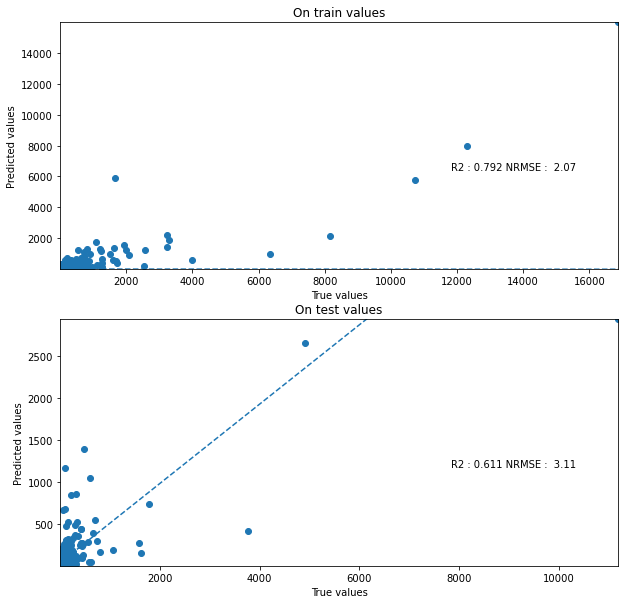

<Figure size 432x288 with 0 Axes>

In [26]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

In [27]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2b"),
        layers.Dense(82, activation="relu", name="layer3"),
        layers.Dense(20, activation="relu", name="layer4"),
        layers.Dense(4, activation = "relu", name = "layer5"),
        layers.Dense(1, activation = 'relu', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 522)               273006    
                                                                 
 layer2b (Dense)             (None, 287)               150101    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 
 layer6 (Dense)              (None, 1)                 5         
                                                                 
Total params: 448,472
Trainable params: 448,472
Non-tr

11/11 [==============================] - 0s 2ms/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


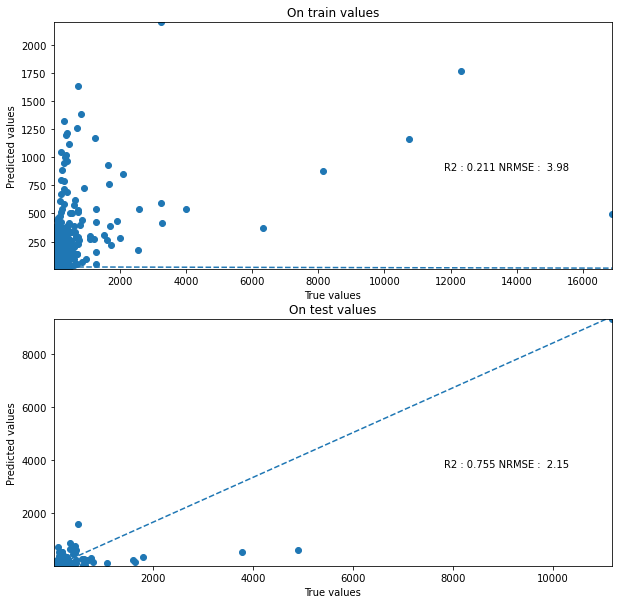

<Figure size 432x288 with 0 Axes>

In [28]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

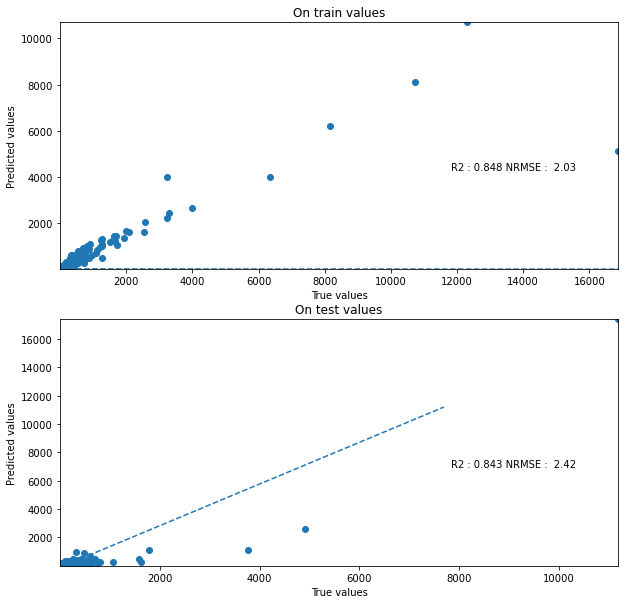

<Figure size 432x288 with 0 Axes>

In [38]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=5000, verbose = 1)

model_rfr = rfr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model_rfr.predict(xtrain), ytest, model_rfr.predict(xtest))

      Iter       Train Loss   Remaining Time 
         1           1.3322            9.99s
         2           1.2978            9.48s
         3           1.2675            9.30s
         4           1.2353            8.96s
         5           1.2127            8.76s
         6           1.1892            8.61s
         7           1.1585            8.65s
         8           1.1319            8.43s
         9           1.1153            8.48s
        10           1.0956            8.42s
        20           0.9510            8.08s
        30           0.8638            8.02s
        40           0.8062            7.87s
        50           0.7570            7.73s
        60           0.7282            7.65s
        70           0.6941            7.53s
        80           0.6747            7.43s
        90           0.6506            7.34s
       100           0.6235            7.28s
       200           0.4931            6.64s
       300           0.4190            5.76s
       40

E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


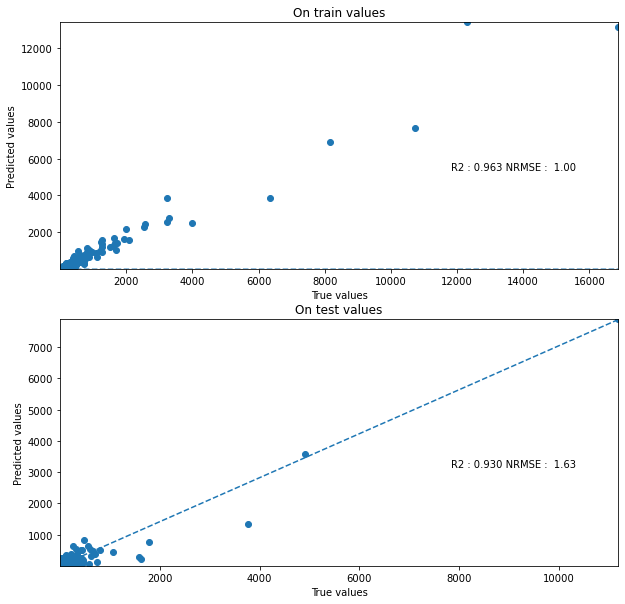

<Figure size 432x288 with 0 Axes>

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 1000, verbose = 1)
model_xgb = gbr.fit(xtrain, ytrain)

true_pred_plot(ytrain, model_xgb.predict(xtrain), ytest, model_xgb.predict(xtest))

[32, 43, 46, 49, 52, 54, 60, 61, 69, 70, 71, 73, 76, 77, 78, 79, 80, 81, 83, 84, 86, 88, 90, 93, 95, 97, 98, 99, 100, 101, 102, 107, 111, 112, 114, 116, 118, 120, 122, 124, 125, 126, 128, 129, 130, 132, 133, 134, 135, 136, 137, 141, 142, 143, 146, 147, 148, 151, 152, 154, 158, 159, 162, 163, 165, 172, 173, 174, 176, 177, 178, 180, 183, 187, 190, 191, 192, 194, 195, 202, 203, 204, 206, 208, 209, 210, 212, 213, 214, 216, 217, 221, 225, 226, 229, 231, 233, 238, 239, 241, 242, 243, 247, 248, 258, 261, 262, 263, 264, 272, 274, 275, 277, 278, 279, 281, 283, 288, 290, 295, 297, 298, 301, 303, 305, 308, 310, 314, 315, 321, 322, 328, 330, 336, 337, 340, 341, 342, 343, 347, 348, 350, 351, 354, 357, 360, 361, 362, 364, 366, 371, 372, 373, 378, 383, 385, 387, 390, 392, 393, 394, 396, 398, 399, 400, 401, 405, 411, 415, 418, 427, 432, 438, 443, 445, 446, 447, 454, 464, 467, 468, 469, 474, 476, 485, 487, 491, 494, 496, 497, 505, 509]


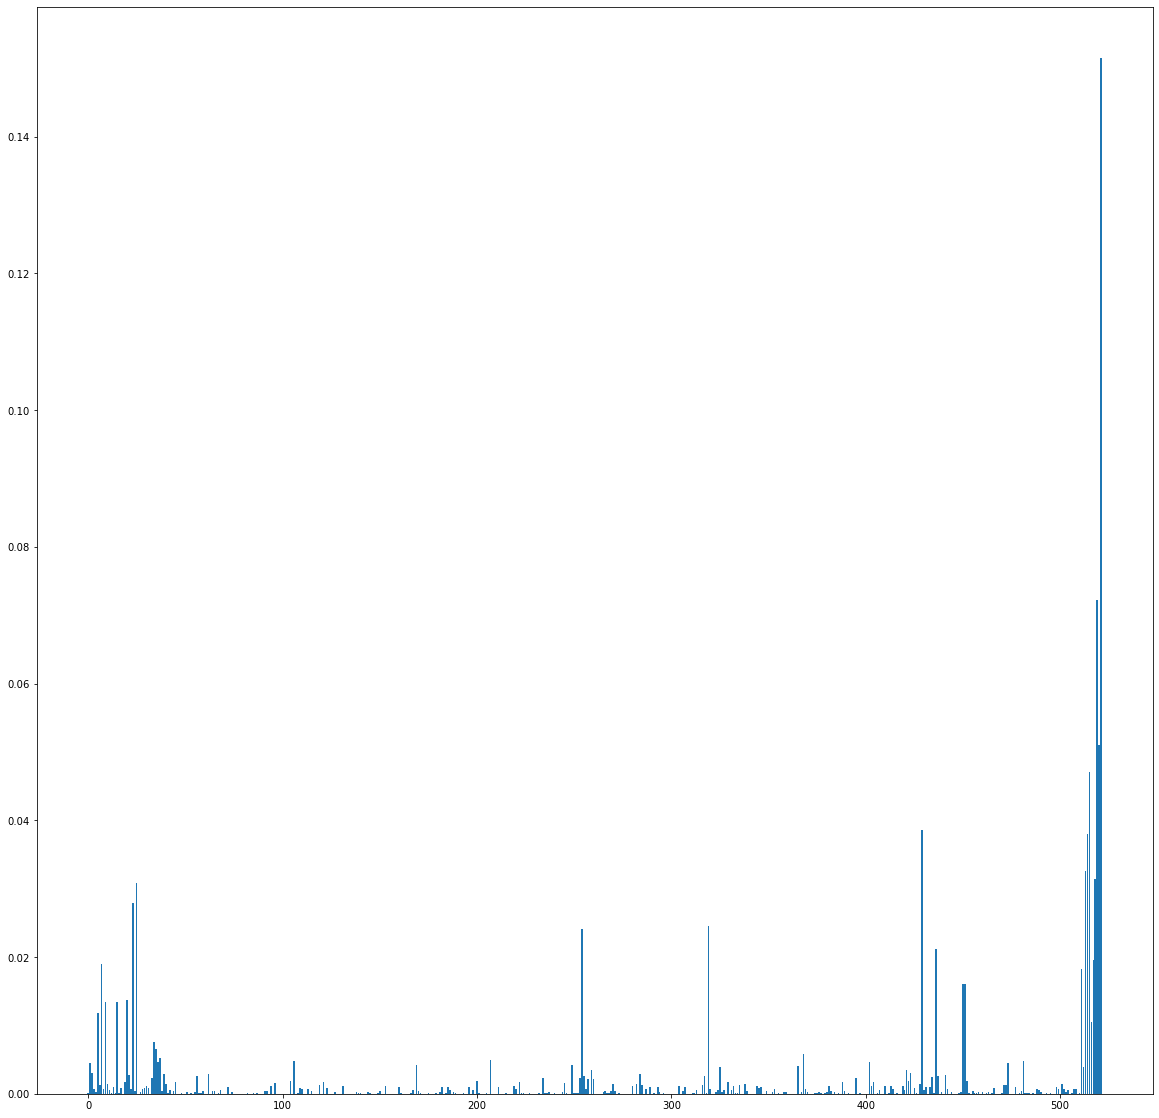

In [31]:
importance = model.feature_importances_
nul_col = []
for i,v in enumerate(importance):
    if v == 0:
        nul_col.append(i)
print(nul_col)
# plot feature importance
fig, ax = plt.subplots(figsize = (20,20))
ax.bar([x for x in range(len(importance))], importance)
plt.show()

In [43]:
def r2(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    line_reg_test  = line_reg.fit(pred,y)
    r2_value =  line_reg_test.score(pred,y)
    return r2_value

def rmse(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    rmse_value = np.sqrt(metrics.mean_squared_error(y,pred))
    return rmse_value

def nrmse(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    nrmse_value = (np.sqrt(metrics.mean_squared_error(y,pred))/np.mean(y))
    return nrmse_value
                   
def mae(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    mae_value = metrics.mean_absolute_error(y,pred)
    return mae_value

11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
E:\temp\ipykernel_15100\4294875676.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


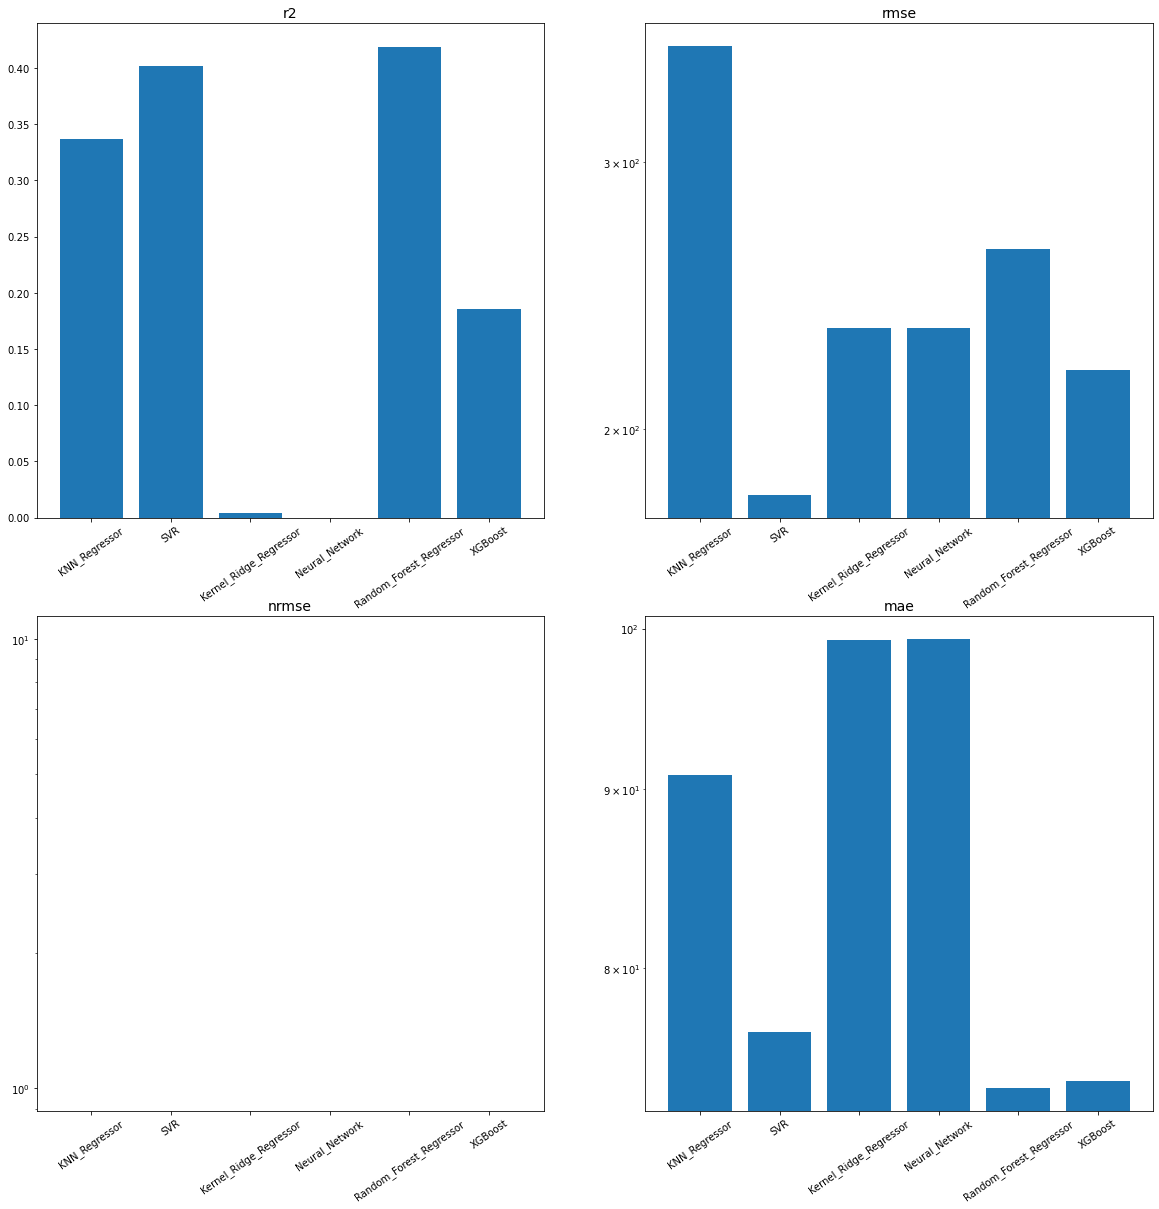

In [44]:
metrics_all = {}

models = [model_kn,svr,model_kr,model3,model_rfr,model_xgb]
r2l=[]
rmsel=[]
nrmsel=[]
mael=[]

for i in models:
    r2l.append(r2(i.predict(xtest),ytest))
    rmsel.append(rmse(i.predict(xtest), ytest))
    nrmsel.append(nrmse(i.predict(xtest), ytest))
    mael.append(mae(i.predict(xtest), ytest))
    
metrics_all['r2'] = r2l
metrics_all['rmse'] = rmsel
metrics_all['nrmse'] = nrmsel
metrics_all['mae'] = mael

model_names = ['KNN_Regressor', 'SVR', 'Kernel_Ridge_Regressor','Neural_Network', 'Random_Forest_Regressor', 'XGBoost']
df_metrics = pd.DataFrame(metrics_all, index = model_names)

fig = plt.figure(figsize=(20, 20))
for i in range(df_metrics.shape[1]):
    ax = fig.add_subplot(2,2, (i+1))
    b = ax.bar(x=df_metrics.index,height = df_metrics.iloc[:, i])
    ax.set_title(df_metrics.columns[i], fontsize=14)
    ax.tick_params(axis='x', labelrotation = 35)
    if i != 0:
        ax.set_yscale('log')